# Numerical Study on Project Crashing

## Imports and Figure Settings

In [1]:
import numpy as np
import pandas as pd
import rsome as rso
from rsome import ro
from rsome import grb_solver as grb
import networkx as nx

from multiprocess import Pool

In [2]:
import matplotlib.pyplot as plt
import matplotlib

rc = {"mathtext.fontset": "cm",
      "text.latex.preamble": r"\usepackage{amsmath}"}
matplotlib.rc('text', usetex=True)
plt.rcParams.update(rc)
plt.rcParams['font.family'] = 'Times New Roman'

nusblue = [0/255, 66/255, 130/255]
nusorange = [239/255, 124/255, 1/255]

fs = 15   # label font size
fl = 14   # legend font size
ft = 12   # tick font size

## Parameters

### Network of Tasks

In [3]:
row = 4                                     # Number of rows of the project flow network
col = 5                                     # Number of columns of the project flow network

xdata, ydata = np.meshgrid(range(col), range(row))
nodes = pd.Series(range(xdata.size), 
                  index=[(x, y) for x, y in zip(xdata.flatten(), ydata.flatten())])
nodes

edges_dict = {'from': [], 'to': []}
for i in range(col):
    for j in range(row):
        if i + 1 < col:
            edges_dict['from'].append(nodes[i, j])
            edges_dict['to'].append(nodes[i+1, j])
            
        
        if j + 1 < row:
            edges_dict['from'].append(nodes[i, j])
            edges_dict['to'].append(nodes[i, j+1])

np.random.seed(0)
edges = pd.DataFrame(edges_dict, dtype=int)

pos = nodes.index.values

The variable `edges` above provides the edge information of the project network, and it is used to define the set $\mathcal{A}$. The other variable `pos` indicates the location of each task node used for visualization. 

### The nominal values of `zhat`

In [4]:
I = row * col                                # Total number of tasks of the project
zhat = 10 * np.ones(I)                       # The mean value of project duration of each task

### Target 

In [5]:
target = (row+col-1) * zhat.mean() * 0.75    # The target completion time 
target

60.0

### Others

In [6]:
b = 0.5                                      # The maximum allowable percentage reduction for all tasks
c = 2 + 5*np.arange(I)/I                     # The cost of duration reduction for each task

### Samples

#### Functions for sample generation

In [7]:
def sample_gen(zhat, dev, size):
    """
    The function sample_gen generates random samples uniformly distributed
    within the range [zhat - dev, zhat + dev]. The sample size is specified
    by the argument size. 
    """
    
    n = len(zhat)
    
    return zhat + dev * (2*np.random.rand(size, n) - 1)

In [8]:
np.random.seed(0)

sigma = 6 * np.random.rand(I)                        # The maximum deviation from the mean zhat
Nin = 100
Nout = 2000

zin = sample_gen(zhat, sigma, Nin)                   # In-sample data
zout = sample_gen(zhat, sigma, Nout)                 # Out-of-sample data

In [9]:
ub = zin.max(axis=0)                                 # The upper bounds estimated using the in-sample data
lb = zin.min(axis=0)                                 # The lower bounds estimated using the in-sample data

zmean = zin.mean(axis=0)                             # The mean values estimated using the in-sample data
dev = I * abs(zin - zmean).mean(axis=0)              
Dmat = np.diag(dev)                                  # The D matrix estimated using the in-sample data

uhat = zin - zin.mean(axis=0)
Dinv = np.linalg.inv(Dmat)
delta = (abs(uhat) @ Dinv).sum(axis=1).max()         # The delta value estimated using the in-sample data

## Models
### Function for the Deterministic Model

The deterministic model below

$$
\begin{align}
\text{min}~&\pmb{c}^{\top}\pmb{x} \\
\text{s.t.}~&\pmb{y}_{I+1} \leq \tau \\
&y_j - y_i \geq \hat{z}_i (1-x_i)  &\forall (i, j)\in \mathcal{A} \\
&\pmb{y} \geq \pmb{0} \\
&\pmb{x}\in[\pmb{0}, \pmb{b}]. 
\end{align}
$$

is used to achieve the minimum budget under the predicted task duration $\hat{\pmb{z}}$. 

In [10]:
def det_proma(b, c, target, zhat):
    """
    The function det_proma() solves the deterministic project
    management problem.
    
    Parameters
    ----------
    b : float or np.ndarray
        The upper bound of the here-and-now decision x
    c : np.ndarray
        The cost coefficient of each node
    target : float
        The target value for the total completion time.
    zhat : np.ndarray
        The predicted values of the random variable z
        
    Returns
    -------
    xs : np.ndarray
        The optimal solution for the decision variable x.
    cost : float
        The optimal objective value in terms of the total cost.
    solution : rsome.lp.Solution
        The solution information of the model
    """
    
    model = ro.Model()

    I = len(c)
    x = model.dvar(I)
    y = model.dvar(I + 1)

    model.min(c@x)
    model.st(x >= 0, x <= b)
    model.st(y[-1] <= target)
    model.st(y >= 0)

    idx_i = edges['from'].values
    idx_j = edges['to'].values
    model.st(y[idx_j] - y[idx_i] >= zhat[idx_i]*(1-x[idx_i]))
    model.st(y[I] - y[I-1] >= zhat[I-1]*(1-x[I-1]))

    model.solve(grb, display=False)
    
    return x.get(), model.get(), model.solution

The following deterministic model (page 21 in the paper) is used to achieve a benchmark decision under a given budget of $V + \Gamma$:

$$
\begin{align}
\text{min}~&\pmb{y}_{I+1} \\
\text{s.t.}~&y_j - y_i \geq \hat{z}_i (1-x_i)  &\forall (i, j)\in \mathcal{A} \\
&\pmb{y} \geq \pmb{0} \\
&\pmb{c}^{\top}\pmb{x} \leq V + \Gamma \\
&\pmb{x}\in[\pmb{0}, \pmb{b}], 
\end{align}
$$

where $\Gamma$ is the extra budget for duration reduction.

In [11]:
def det_proma_gamma(b, c, v, gamma, zhat):
    """
    The function det_proma_gamma() solves the deterministic project
    management problem that minimizes the completion time under a cost
    budget of v + gamma.
    
    Parameters
    ----------
    b : float or np.ndarray
        The upper bound of the here-and-now decision x
    c : np.ndarray
        The cost coefficient of each node
    v : float
        The total cost of the corresponding determnistic problem.
    gamma : float
        The extra budget.
    zhat : np.ndarray
        The predicted values of the random variable z
        
    Returns
    -------
    xs : np.ndarray
        The optimal solution for the decision variable x.
    cost : float
        The optimal objective value in terms of the total cost.
    solution : rsome.lp.Solution
        The solution information of the model
    """
    
    model = ro.Model()

    I = len(c)
    x = model.dvar(I)
    y = model.dvar(I + 1)

    model.min(y[-1])
    model.st(c@x <= v + gamma)
    model.st(x >= 0, x <= b)
    model.st(y >= 0)

    idx_i = edges['from'].values
    idx_j = edges['to'].values
    model.st(y[idx_j] - y[idx_i] >= zhat[idx_i]*(1-x[idx_i]))
    model.st(y[I] - y[I-1] >= zhat[I-1]*(1-x[I-1]))

    model.solve(grb, display=False)
    
    return x.get(), model.get(), model.solution

### Function for the Robust Satisficing Model

#### Robust satisficing model with a $1$-norm support

The robust satisficing model below

$$
\begin{align}
\text{min}~& \kappa \\
\text{s.t.}~&\pmb{y}_{I+1}(\pmb{r}, \pmb{s}) - \kappa u \leq \tau &\forall (\pmb{z}, \pmb{r}, \pmb{s}, u) \in \bar{\mathcal{Z}}\\
&y_j(\pmb{r}, \pmb{s}) - y_i(\pmb{r}, \pmb{s}) \geq \hat{z}_i (1-x_i)  &\forall (i, j)\in \mathcal{A}, ~\forall (\pmb{z}, \pmb{r}, \pmb{s}, u) \in \bar{\mathcal{Z}} \\
&\pmb{y}(\pmb{r}, \pmb{s}) \geq \pmb{0} &\forall (\pmb{z}, \pmb{r}, \pmb{s}, u) \in \bar{\mathcal{Z}}\\
&\pmb{c}^{\top}\pmb{x} \leq V + \Gamma \\
&\pmb{x}\in[\pmb{0}, \pmb{b}] \\
&\pmb{y} \in \mathcal{L}(2L, N_1), \kappa \geq 0,
\end{align}
$$

is implemented using the affine recourse adaptation introduced in THEOREM 2, where the support $\bar{\mathcal{Z}}$ is defined as

$$
\bar{\mathcal{Z}} = \left\{
(\pmb{z}, \pmb{r}, \pmb{s}, u)\in\mathbb{R}^L\times\mathbb{R}_+^L\times\mathbb{R}_+^L\times\mathbb{R} \left|~
\begin{align}
&\pmb{z} = \pmb{D}(\pmb{r} - \pmb{s}) + \hat{\pmb{z}} \\
&\pmb{1}^{\top}\pmb{r} + \pmb{1}^{\top}\pmb{s} \leq u \\
&u\leq \delta
\end{align}~
\right.
\right\}.
$$

Notice that the support is unbounded if $\delta \rightarrow \infty$. 

In [12]:
def rs_proma(b, c, target, zhat, v, gamma, Dmat, delta=None):
    """
    The function rs_proma() solves the project management problem
    formulated as a robust satisficing model with one-norm support.
    
    Parameters
    ----------
    b : float or np.ndarray
        The upper bound of the here-and-now decision x
    c : np.ndarray
        The cost coefficient of each node
    target : float
        The target value for the total completion time.
    zhat : np.ndarray
        The predicted values of the random variable z
    v : float
        The total cost of the corresponding determnistic problem.
    gamma : float
        The extra budget.
    Dmat : np.ndarray
        A two-dimensional array representing the transformation of
        random variables
    delta : float
        The one-norm support coefficient delta. If delta is None, 
        the support is unbounded, i.e. delta -> infinity.
        
    Returns
    -------
    xs : np.ndarray
        The optimal solution for the decision variable x.
    cost : float
        The optimal objective in terms of the kappa value.
    solution : rsome.lp.Solution
        The solution information of the model
    """
    
    model = ro.Model()

    I = len(c)
    x = model.dvar(I)
    kappa = model.dvar()
    
    z = model.rvar(I)
    r = model.rvar(I)
    s = model.rvar(I)
    u = model.rvar()
    if delta is None:
        uset = (z == Dmat@(r - s) + zhat, (r + s).sum() <= u,
                r >= 0, s >= 0)
    else:
        uset = (z == Dmat@(r - s) + zhat, (r + s).sum() <= u,
                u <= delta, r >= 0, s >= 0)

    y = model.ldr(I + 1)
    y.adapt(r)
    y.adapt(s)
    

    model.minmax(kappa, uset)
    model.st(kappa >= 0)
    model.st(c@x <= v + gamma)
    model.st(x >= 0, x <= b)
    model.st(y[-1] - u*kappa <= target)
    model.st(y >= 0)

    idx_i = edges['from'].values
    idx_j = edges['to'].values
    model.st(y[idx_j] - y[idx_i] >= z[idx_i]*(1-x[idx_i]))
    model.st(y[I] - y[I-1] >= z[I-1]*(1-x[I-1]))

    model.solve(grb, display=False)
    
    return x.get(), c@x(), model.solution

#### Robust Satisficing model with OR mixed support

The robust satisficing model (Equation (10))

$$
\begin{align}
\text{min}~& \kappa \\
\text{s.t.}~& \bar{y}_{I+1} + y_{I+1} \leq \tau \\
&y_j- y_i \geq \hat{z}_i(\alpha - (x_i - \bar{x}_i) & \forall (i, j) \in \mathcal{A} \\
&\bar{y}_j- \bar{y}_i \geq \bar{z}_i(1 - \alpha - \bar{x}_i) & \forall (i, j) \in \mathcal{A} \\
&\sigma_i(\alpha - (x_i - \bar{x}_i)) \leq \kappa &\forall i \in [I]\\
&\bar{\pmb{x}} \leq \pmb{1}(1-\alpha) \\
&\pmb{c}^{\top}\pmb{x} \leq V + \Gamma \\
&\pmb{y}, \bar{\pmb{y}} \geq \pmb{0} \\
&\pmb{x}\in[\pmb{0}, \pmb{b}], \alpha \in [0, 1], \kappa \geq 0, \\
\end{align}
$$

is based on THEOREM 3 and implemented using the following function. 

In [13]:
def rs_proma_or(b, c, target, zhat, v, gamma, Dmat, ub):
    """
    The function rs_proma_or() solves the project management
    problem formulated as a robust satisficing model with infimal
    convolution.
    
    Parameters
    ----------
    b : float or np.ndarray
        The upper bound of the here-and-now decision x
    c : np.ndarray
        The cost coefficient of each node
    target : float
        The target value for the total completion time.
    zhat : np.ndarray
        The predicted values of the random variable z
    v : float
        The total cost of the corresponding determnistic problem.
    gamma : float
        The extra budget.
    Dmat : np.ndarray
        A square matrix for the transformation of the random 
        variable z.
    ub : float or np.ndarray
        The upper bound of the random variable z
    delta : float
        The one-norm support coefficient delta. If delta is None, 
        the support is unbounded, i.e. delta -> infinity.
        
    Returns
    -------
    xs : np.ndarray
        The optimal solution for the decision variable x.
    cost : float
        The optimal objective in terms of the kappa value.
    solution : rsome.lp.Solution
        The solution information of the model
    """
    
    model = ro.Model()

    I = len(c)
    x = model.dvar(I)
    y = model.dvar(I + 1)
    kappa = model.dvar()
    
    xbar = model.dvar(I)
    ybar = model.dvar(I + 1)
    alpha = model.dvar()
    
    model.min(kappa)
    model.st(c@x <= v + gamma)
    model.st(ybar[-1] + y[-1] <= target)
    model.st(Dmat@(alpha - (x - xbar)) <= kappa, 0 <= kappa)
    
    idx_i = edges['from'].values
    idx_j = edges['to'].values
    model.st(y[idx_j] - y[idx_i] >= zhat[idx_i]*(alpha - (x[idx_i] - xbar[idx_i])))
    model.st(y[I] - y[I-1] >= zhat[I-1]*(alpha - (x[I-1] - xbar[I-1])))
    model.st(ybar[idx_j] - ybar[idx_i] >= ub[idx_i]*(1 - alpha - xbar[idx_i]))
    model.st(ybar[I] - ybar[I-1] >= ub[I-1]*(1 - alpha - xbar[I-1]))
    
    model.st(xbar <= 1 - alpha, 0 <= alpha, alpha <= 1)
    model.st(0 <= x, x <= b, y >= 0, ybar >= 0)
    
    model.solve(grb, display=False)
    
    return x.get(), c@x(), model.solution

#### Robust Satisficing model with AR mixed support

The robust satisficing model

$$
\begin{align}
\text{min}~& \kappa \\
\text{s.t.}~&\pmb{y}_{I+1}(\pmb{r}, \pmb{s}) - \kappa u \leq \tau &\forall (\pmb{z}, \pmb{r}, \pmb{s}, u) \in \bar{\mathcal{Z}}\\
&y_j(\pmb{r}, \pmb{s}) - y_i(\pmb{r}, \pmb{s}) \geq \hat{z}_i (1-x_i)  &\forall (i, j)\in \mathcal{A}, ~\forall (\pmb{z}, \pmb{r}, \pmb{s}, u) \in \bar{\mathcal{Z}} \\
&\pmb{y}(\pmb{r}, \pmb{s}) \geq \pmb{0} &\forall (\pmb{z}, \pmb{r}, \pmb{s}, u) \in \bar{\mathcal{Z}}\\
&\pmb{c}^{\top}\pmb{x} \leq V + \Gamma \\
&\pmb{x}\in[\pmb{0}, \pmb{b}] \\
&\pmb{y} \in \mathcal{L}(2L, N_1), \kappa \geq 0,
\end{align}
$$

is implemented using the affine recourse adaptation introduced in THEOREM 2, where $\bar{\mathcal{Z}}$ considers the mixture of a one-norm and box support $\bar{\mathcal{Z}}$:

$$
\bar{\mathcal{Z}} = \left\{
(\pmb{z}, \pmb{r}, \pmb{s}, u)\in\mathbb{R}^L\times\mathbb{R}_+^L\times\mathbb{R}_+^L\times\mathbb{R} \left|~
\begin{align}
&\pmb{z} = \pmb{D}(\pmb{r} - \pmb{s}) + \hat{\pmb{z}} \\
&\pmb{1}^{\top}\pmb{r} + \pmb{1}^{\top}\pmb{s} \leq u \\
&u\leq \delta, ~\underline{\pmb{z}} \leq \pmb{z} \leq \bar{\pmb{z}}
\end{align}~
\right.
\right\}.
$$


In [14]:
def rs_proma_box(b, c, target, zhat, v, gamma, Dmat, lb, ub, delta=None):
    """
    The function rs_proma_box() solves the project management
    problem formulated as a robust satisficing model with mixed
    one-norm and box support. 
    
    Parameters
    ----------
    b : float or np.ndarray
        The upper bound of the here-and-now decision x
    c : np.ndarray
        The cost coefficient of each node
    target : float
        The target value for the total completion time.
    zhat : np.ndarray
        The predicted values of the random variable z
    v : float
        The total cost of the corresponding determnistic problem.
    gamma : float
        The extra budget.
    Dmat : np.ndarray
        A square matrix for the transformation of the random 
        variable z.
    lb : float or np.ndarray
        The lower bound of the random variable z.
    ub : float or np.ndarray
        The upper bound of the random variable z.
    delta : float
        The one-norm support coefficient delta. If delta is None, 
        the support is unbounded, i.e. delta -> infinity.
        
    Returns
    -------
    xs : np.ndarray
        The optimal solution for the decision variable x.
    cost : float
        The optimal objective in terms of the kappa value.
    solution : rsome.lp.Solution
        The solution information of the model
    """
    
    model = ro.Model()

    I = len(c)
    x = model.dvar(I)
    kappa = model.dvar()
    
    z = model.rvar(I)
    r = model.rvar(I)
    s = model.rvar(I)
    u = model.rvar()
    
    if delta is None:
        uset = (z == Dmat@(r - s) + zhat, (r + s).sum() <= u, 
                z >= lb, z <= ub,
                r >= 0, s >= 0)
    else:
        uset = (z == Dmat@(r - s) + zhat, (r + s).sum() <= u, 
                z >= lb, z <= ub, u <= delta,
                r >= 0, s >= 0)
    
    y = model.ldr(I + 1)
    y.adapt(r)
    y.adapt(s)
    
    model.minmax(kappa, uset)
    model.st(kappa >= 0)
    model.st(c@x <= v + gamma)
    model.st(x >= 0, x <= b)
    model.st(y[-1] - u*kappa <= target)
    model.st(y >= 0)

    idx_i = edges['from'].values
    idx_j = edges['to'].values
    model.st(y[idx_j] - y[idx_i] >= z[idx_i]*(1-x[idx_i]))
    model.st(y[I] - y[I-1] >= z[I-1]*(1-x[I-1]))

    model.solve(grb, display=False)
    
    return x.get(), c@x(), model.solution

## Function for Simulations

### Simulation under One Observation of Uncertainty

In [15]:
def one_sim_proma(b, c, xs, zs):
    """
    The function one_sim_proma() simulates the project management
    problem under a given solution of x and one observation of
    random variable z.
    
    Parameters
    ----------
    b : float or np.ndarray
        The upper bound of the here-and-now decision x
    c : np.ndarray
        The cost coefficient of each node
    xs : np.ndarray
        The given solution of the here-and-now decision x.
    zs : np.ndarray
        An observation of the random varaible z.
        
    Returns
    -------
    yend : float
        The total completion time, i.e. y[-1].
    """
    
    model = ro.Model()

    I = len(c)
    y = model.dvar(I + 1)

    model.min(y[-1])
    model.st(y >= 0)

    idx_i = edges['from'].values
    idx_j = edges['to'].values
    model.st(y[idx_j] - y[idx_i] >= zs[idx_i]*(1-xs[idx_i]))
    model.st(y[I] - y[I-1] >= zs[I-1]*(1-xs[I-1]))

    model.solve(grb, display=False)
    
    return y.get()[-1]

### Simulation for all Out-of-Sample Data

In [16]:
def sim_proma(b, c, xs, zout, n_jobs=None):
    """
    The function one_sim_proma() simulates the project management
    problem under a given solution of x and one observation of
    random variable z.
    
    Parameters
    ----------
    b : float or np.ndarray
        The upper bound of the here-and-now decision x
    c : np.ndarray
        The cost coefficient of each node
    xs : np.ndarray
        The given solution of the here-and-now decision x.
    zout : np.ndarray
        A two-dimensional array representing a number of observations 
        of the random varaible z.
    n_jobs : int or None
        The number of jobs carried out parallelly while doing the 
        simulation. The simulation is conducted with a single thread
        if it is specified to be None.
        
    Returns
    -------
    ctime : float
        The complete time of the given decision under different
        realizations of the random variable z. 
    """
    
    
    if n_jobs is None:
        ctime = []
        for s in range(len(zout)):
            ctime.append(one_sim_proma(b, c, xs, zout[s]))
    else:
        with Pool(n_jobs) as p:
            params = [[b, c, xs, zout[s]] for s in range(len(zout))]
            ctime = p.starmap(one_sim_proma, params)
    
    return ctime

## Numerical Case Studies

### Performance of Solutions

#### Deterministic model for calculating the minimum budget $V$

In [17]:
xdet, cost, sol = det_proma(b, c, target, zmean)
v = cost

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-11


#### Solution of models and simulations

In [18]:
ratios = np.arange(0, 1.6, 0.1)

ctime_rs = {}
ctime_rs_delta = {}
ctime_rs_ic = {}
ctime_rs_box = {}
ctime_dmt = {}
for pct in ratios:
    gamma = v * pct
    
    xs, obj, sol = rs_proma(b, c, target, zmean, v, gamma, Dmat)
    ctime_rs[pct] = sim_proma(b, c, xs, zout, n_jobs=12)
    
    xs, obj, sol = rs_proma(b, c, target, zmean, v, gamma, Dmat, delta)
    ctime_rs_delta[pct] = sim_proma(b, c, xs, zout, n_jobs=12)
    
    xs, objx, sol = rs_proma_or(b, c, target, zmean, v, gamma, Dmat, ub)
    ctime_rs_ic[pct] = sim_proma(b, c, xs, zout, n_jobs=12)
    
    xs, obj, sol = rs_proma_box(b, c, target, zmean, v, gamma, Dmat, lb, ub)
    ctime_rs_box[pct] = sim_proma(b, c, xs, zout, n_jobs=12)
    
    xd, obj, sol = det_proma_gamma(b, c, v, gamma, zmean)
    ctime_dmt[pct] = sim_proma(b, c, xd, zout, n_jobs=12)

ctime_rs = pd.DataFrame(ctime_rs)
ctime_rs_delta = pd.DataFrame(ctime_rs_delta)
ctime_rs_ic = pd.DataFrame(ctime_rs_ic)
ctime_rs_box = pd.DataFrame(ctime_rs_box)
ctime_dmt = pd.DataFrame(ctime_dmt)

#### Visualizing Performance

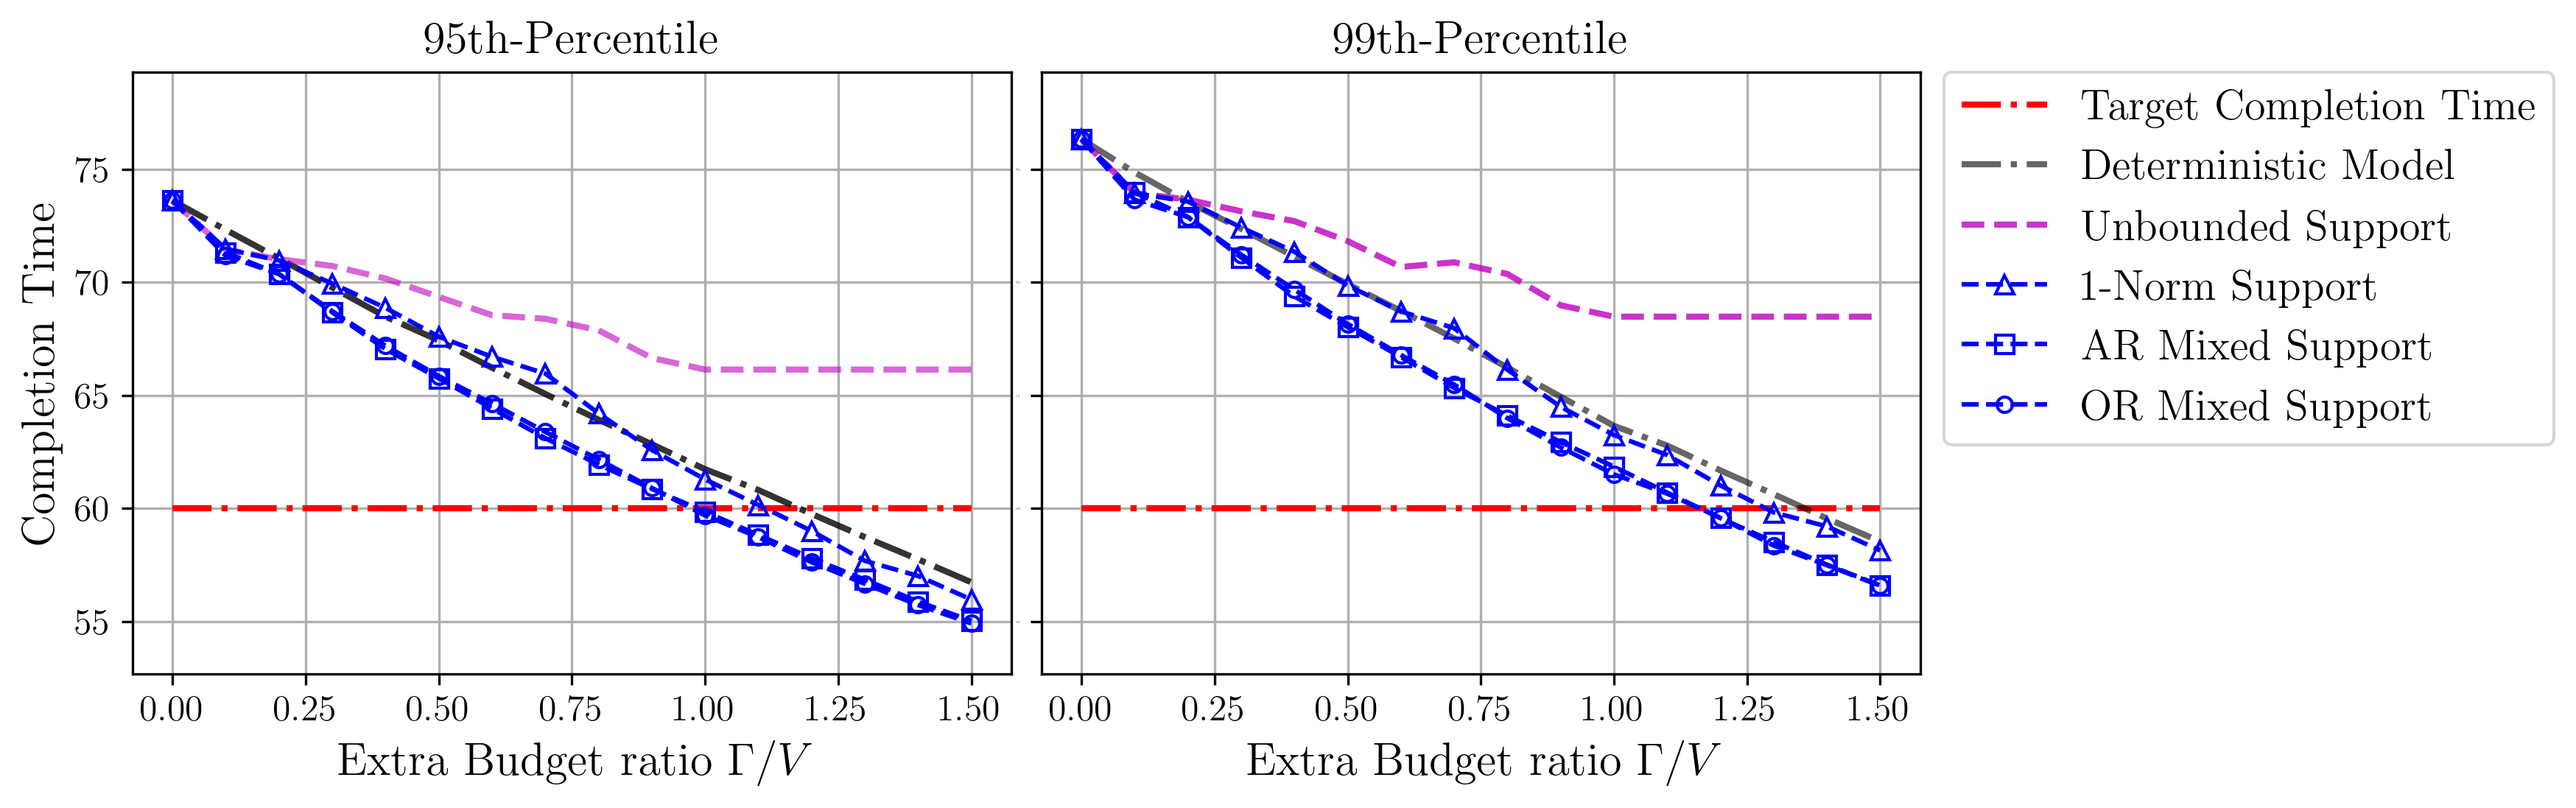

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(11.5, 3.5), dpi=300)

axes[0].hlines(target, ratios[0], ratios[-1], 
               color='r', linestyle='-.', linewidth=2, alpha=1,
               label='Target Completion Time')
axes[0].plot(ratios, (ctime_dmt).quantile(0.95), 
             color='k', linestyle='-.', linewidth=2, alpha=0.8, 
             label='Deterministic Model')
axes[0].plot(ratios, (ctime_rs).quantile(0.95), 
             color='m', linestyle='--', linewidth=2, alpha=0.6, 
             label=r'Unbounded Support')
axes[0].plot(ratios, ctime_rs_delta.quantile(0.95), 
             color='b', marker='^', linestyle='--', markersize=6, markerfacecolor='none',
             label=r'$1$-Norm Support')
axes[0].plot(ratios, ctime_rs_box.quantile(0.95), 
             color='b', marker='s', linestyle='--', markersize=6, markerfacecolor='none',
             label=r'AR Mixed Support')
axes[0].plot(ratios, ctime_rs_ic.quantile(0.95), 
             color='b', marker='o', linestyle='--', markersize=5, markerfacecolor='none',
             label='OR Mixed Support')
axes[0].set_ylim([52.7, 79.3])
axes[0].grid()
axes[0].set_xlabel(r'Extra Budget ratio $\Gamma/V$', fontsize=fs)
axes[0].set_ylabel('Completion Time', fontsize=fs)
axes[0].xaxis.set_tick_params(labelsize=ft)
axes[0].yaxis.set_tick_params(labelsize=ft)
axes[0].set_title('$95$th-Percentile', fontsize=fs)

axes[1].hlines(target, ratios[0], ratios[-1], 
               color='r', linestyle='-.', linewidth=2, alpha=1,
               label='Target Completion Time')
axes[1].plot(ratios, (ctime_dmt).quantile(0.99), 
             color='k', linestyle='-.', linewidth=2, alpha=0.6, 
             label='Deterministic Model')
axes[1].plot(ratios, (ctime_rs).quantile(0.99), 
             color='m', linestyle='--', linewidth=2, alpha=0.8, 
             label=r'Unbounded Support')
axes[1].plot(ratios, ctime_rs_delta.quantile(0.99), 
             color='b', marker='^', linestyle='--', markersize=6, markerfacecolor='none',
             label=r'$1$-Norm Support')
axes[1].plot(ratios, ctime_rs_box.quantile(0.99), 
             color='b', marker='s', linestyle='--', markersize=6, markerfacecolor='none',
             label=r'AR Mixed Support')
axes[1].plot(ratios, ctime_rs_ic.quantile(0.99), 
             color='b', marker='o', linestyle='--', markersize=5, markerfacecolor='none',
             label='OR Mixed Support')
axes[1].set_ylim([52.7, 79.3])
axes[1].grid()
axes[1].set_xlabel(r'Extra Budget ratio $\Gamma/V$', fontsize=fs)
axes[1].xaxis.set_tick_params(labelsize=ft)
axes[1].yaxis.set_tick_params(labelsize=0)
axes[1].legend(bbox_to_anchor=(1.003, 1.035), fontsize=fl)
axes[1].set_title('$99$th-Percentile', fontsize=fs)

plt.tight_layout(pad=0.15)
plt.show()

In [20]:
(ctime_dmt > target).mean()[0]

0.935

#### Visualizing Decisions

In [21]:
index = np.argwhere(ctime_rs_ic.quantile(0.95).values < target).flatten()[0]

index

10

In [22]:
gamma = v * ratios[index]
    
xrs, obj, sol = rs_proma_or(b, c, target, zmean, v, gamma, Dmat, ub)
xdmt, obj, sol = det_proma_gamma(b, c, v, gamma, zmean)

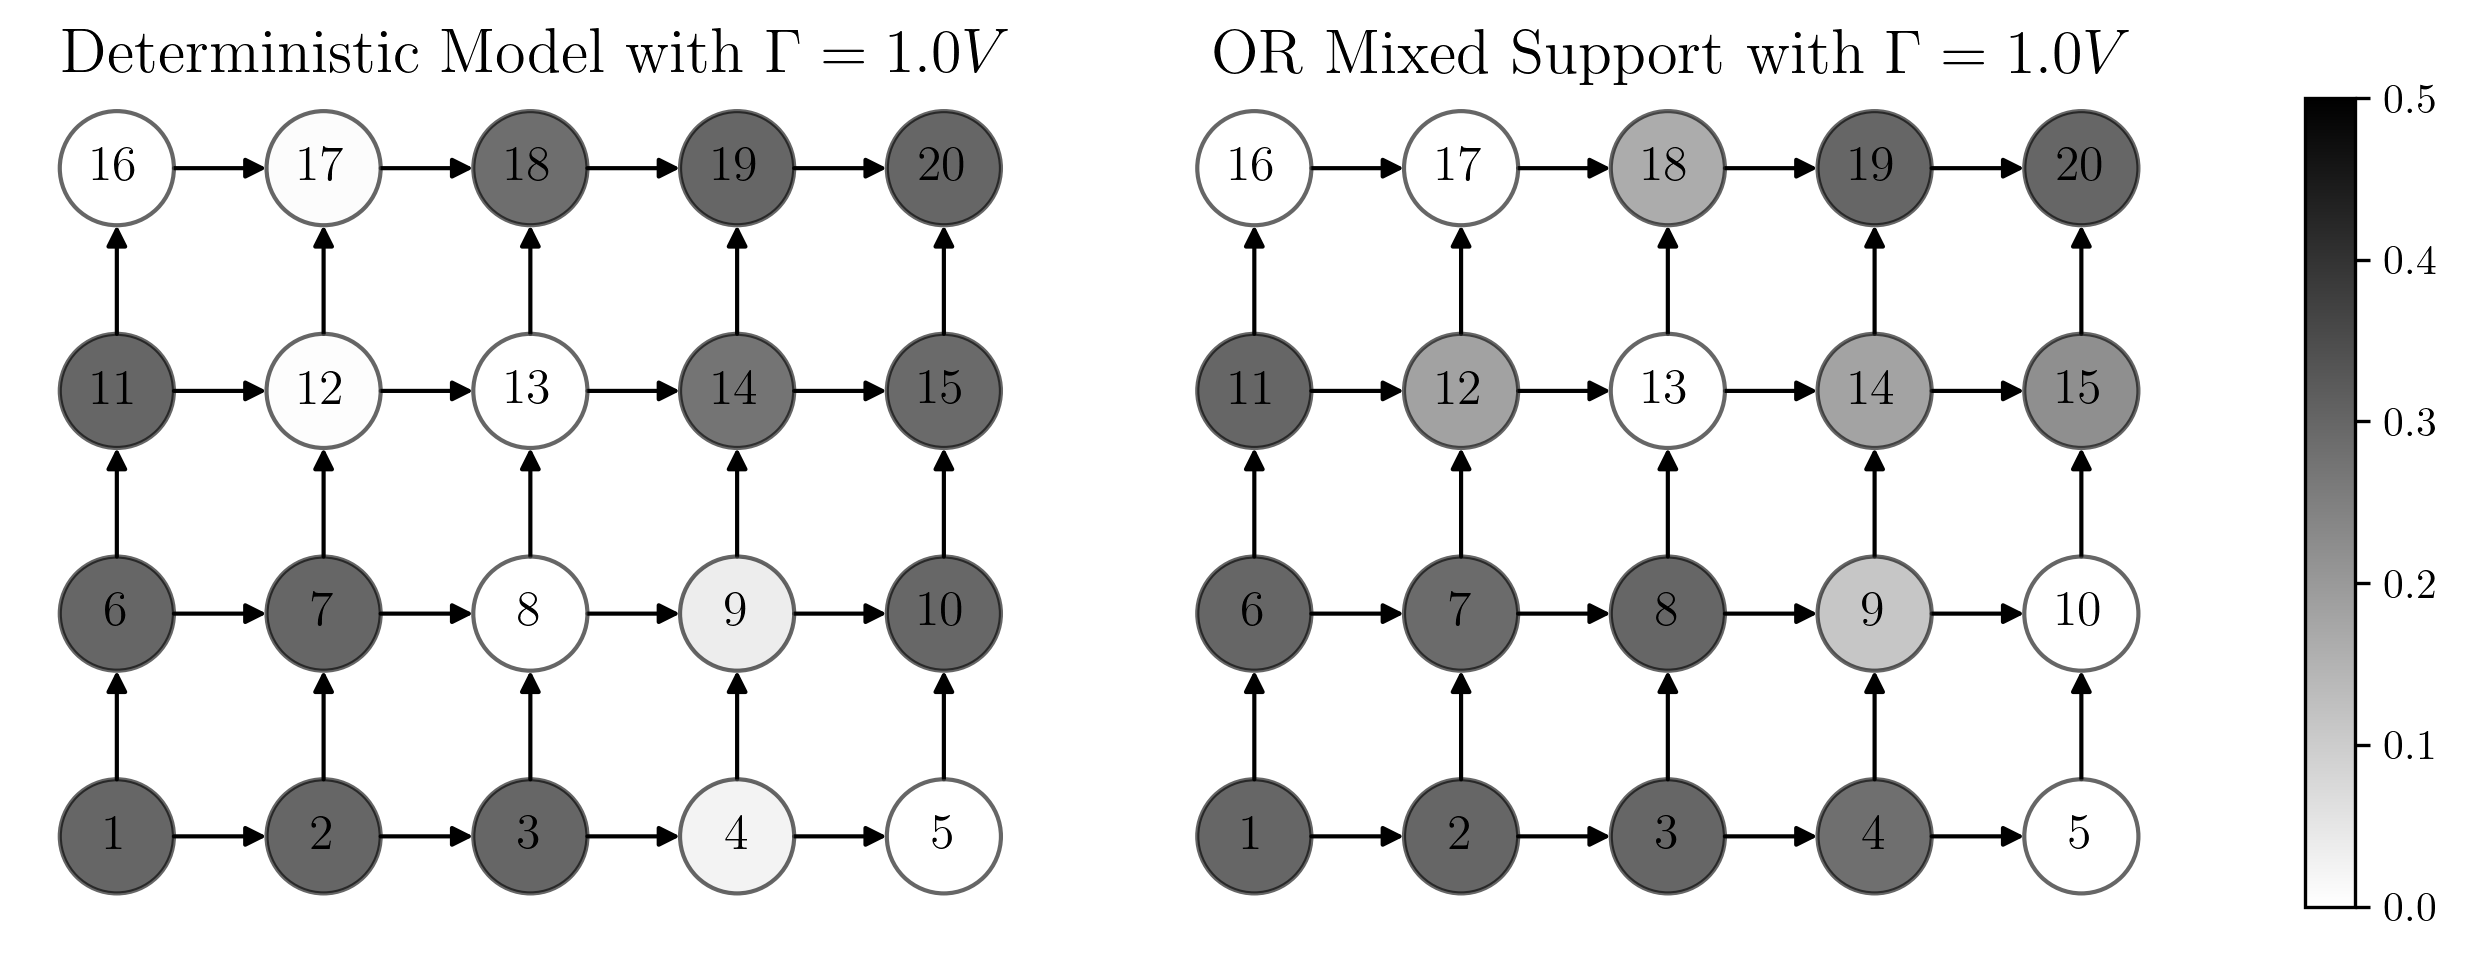

In [23]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3.5), width_ratios=[4, 4, 0.2], dpi=300)

ax = axes[0]
g = nx.DiGraph()
for node in range(1, len(pos)+1):
    g.add_node(node)
for idx, r in edges.iterrows():
    g.add_edge(r['from']+1, r['to']+1)
pos_se = pd.Series(pos)
pos_se.index = np.array(pos_se.index) + 1
node_size=750
vmin, vmax = 0, b
cmap = 'gray_r'
nx.draw_networkx_nodes(g, pos_se, node_color=xdmt, edgecolors='k',
                       cmap=cmap, vmin=vmin, vmax=vmax, alpha=0.6,
                       node_size=node_size, ax=ax)
nx.draw_networkx_labels(g, pos_se, ax=ax)
nx.draw_networkx_edges(g, pos_se, edge_color='k', 
                       node_size=node_size, arrows=True, ax=ax)
ax.set_title(f'Deterministic Model with $\Gamma = {ratios[index].round(2)}V$', fontsize=fs)
ax.axis('off')

ax = axes[1]
g = nx.DiGraph()
for node in range(1, len(pos)+1):
    g.add_node(node)
for idx, r in edges.iterrows():
    g.add_edge(r['from']+1, r['to']+1)
pos_se = pd.Series(pos)
pos_se.index = np.array(pos_se.index) + 1
node_size=750
vmin, vmax = 0, b
cmap = 'gray_r'
gamma = 1 * v
nx.draw_networkx_nodes(g, pos_se, node_color=xrs, edgecolors='k',
                       cmap=cmap, vmin=vmin, vmax=vmax, alpha=0.6,
                       node_size=node_size, ax=ax)
nx.draw_networkx_labels(g, pos_se, ax=ax)
nx.draw_networkx_edges(g, pos_se, edge_color='k', 
                       node_size=node_size, arrows=True, ax=ax)
ax.set_title(f'OR Mixed Support with $\Gamma = {ratios[index].round(2)}V$', fontsize=fs)
ax.axis('off')

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = fig.colorbar(sm, cax=axes[2])

plt.show()